In [1]:
from dotenv import load_dotenv 
import csv
import pandas as pd
import datetime as dt
import seaborn as sns
import tweepy
import typing as T
import os
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import tz
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.ops import nearest_points
from shapely.geometry import Point
import geopandas as gpd
import numpy as np

In [2]:
load_dotenv()
sns.set_context('notebook',font_scale=1.25)

In [3]:
TZ= 'EST5EDT'
consumer_key = os.getenv("TWITTER_API_KEY")
consumer_secret = os.getenv("TWITTER_API_SECRET")
access_key = os.getenv("TWITTER_API_ACCESS_TOKEN")
access_token_secret = os.getenv("TWITTER_API_ACCESS_TOKEN_SECRET")

In [4]:
DATA_DIR = '../data/'

In [5]:

def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_token_secret)
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200, tweet_mode='extended')
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, tweet_mode='extended')
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.full_text] for tweet in alltweets]
    
    #write the csv  
    with open(f'{DATA_DIR}_new_{screen_name}_tweets.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    
    pass

In [6]:
# get_all_tweets('waldenpondstate')
# get_all_tweets('massdcr')
# df = pd.read_csv('new_massdcr_tweets.csv',parse_dates=['created_at'])

In [7]:
def pre_process_tweet_csv(filename: str, start_dt: pd.Timestamp, end_dt: pd.Timestamp, do_remove_inconsistent_tweets: bool) -> pd.DataFrame:
    df = pd.read_csv(filename,parse_dates=['created_at'])
    df['created_at'] = df['created_at'].apply(lambda x: x.tz_localize('UTC').tz_convert('EST5EDT'))
    df['text'] = df['text'].apply(lambda x: x.lower().replace('-','').replace(',', ' '))
    df = df.loc[df['created_at'].between(start_dt,end_dt)].sort_values(by='created_at')
    print(f"num df tweets in range: {len(df)}")
    # parsed_df has columns effective_time and is_open
    parsed_df = df.apply(lambda x: parse_tweet(x['text'],x['created_at']), axis=1)
    df = pd.concat([df,parsed_df],axis=1)
    
    print(f"num re-reopened tweets: {df['open'].sum()}")
    print(f"num re-reopened tweets with parsed times: {df.loc[df['effective_time'].notna(),'open'].sum()}")
    print(f"num closed tweets: {(df['open']==False).sum()}")
    print(f"num closed tweets with parsed times: {((df['effective_time'].notna())&(df['open']==False)).sum()}")
    df = df.loc[df['open'].notna()].drop(columns=['id'])
    print(f"num tweets: {len(df)}")
    df.sort_values(by='effective_time', inplace=True)
    
    
    def remove_inconsistent_tweets(x: pd.DataFrame):
        """ removes tweets that don't change is_open from last tweet
        
        """
#         print(x)
        last_open_value = True
        good_indices = []
        for i, tweet in x.iterrows():
#             print(tweet)
            if last_open_value==tweet['open']:
                continue
            else:
                good_indices.append(i)
                last_open_value = tweet['open']
        return x.loc[good_indices]
    if do_remove_inconsistent_tweets:
        df = df.groupby(df['effective_time'].dt.date).apply(lambda x: remove_inconsistent_tweets(x)).reset_index(drop=True)
    df['original_data'] = True
    print(f"num tweets after removing incosistent: {len(df)}")
    return df

In [8]:
def parse_effective_hour_str(text: str) -> T.Optional[str]:
    """ return time from tweet

    e.g. 
    >parse_effective_time_text(' open at 4:00pm')
    >'4:00pm'
    # TODO improve the regex and match logic
    """
    matches = re.findall('((1[0-2]|0?[1-9]):([0-5][0-9])\s?([AaPp][Mm]))|((1[0-2]|0?[1-9])([AaPp][Mm]))',text)
    if len(matches)==0:
        return None
    else:
        matches = matches[0]
        reopen_time_str = None 
        for x in matches:
            if x != '':
                reopen_time_str = x
                break
        return reopen_time_str
        

In [9]:
def parse_effective_time(text: str, created_at: pd.Timestamp):
    reopen_time = parse_effective_hour_str(text)
    if reopen_time is not None:
        date_str = created_at.date().strftime('%Y-%m-%d')
        reopen_datetime_str =  date_str + ' ' + reopen_time
        return pd.Timestamp(ts_input=reopen_datetime_str, tz=TZ)
    else:
        return None

In [10]:
def parse_tweet(text: str, created_at: pd.Timestamp):
    """ parses tweet and returns df (is_open, effective_time)"""
        
    is_open = parse_is_open_from_text(text)
    effective_time = parse_effective_time(text, created_at)
    # if time exists and is less than 1 hour from created_at time, use it
    if effective_time and ((effective_time-created_at).total_seconds()/3600<1):
        pass
    else:
        effective_time = created_at
    
    return pd.Series({"open": is_open, "effective_time": effective_time})


In [11]:
def parse_is_open_from_text(text: str) -> T.Optional[bool]:
    """ Parse text to decide if Pond opening, closing or neither

    :returns: True if opening, False if closing, None if neither

    """
    reopen = False
    close = False

    if 'reopen' in text:
        reopen = True
    if 'close' in text:
        close = True

    if (reopen and close):
        #scan through and take first occurence
        for i in text.split(' '):
            if 'reopen' in i:
                return True
            elif 'close' in i:
                return False 

    elif reopen:
        return True
    elif close:
        return False
    else:
        return None

In [12]:
def resample_day(x: pd.DataFrame, freq='1H', open_hour=7, close_hour=18):
    tstr = 'effective_time'
    day = x.iloc[0][tstr].date().strftime("%Y-%m-%d")
    start = day +f' {open_hour}:00'
    end = day +f' {close_hour}:00'
    new_index = pd.DataFrame({'time':pd.date_range(start=start,end=end,freq=freq,tz=TZ)})
    x = pd.merge_asof(new_index, x, left_on='time', right_on='effective_time', direction='backward', )
    x.loc[x['original_data'].notna() & x[['original_data','text']].duplicated(), 'original_data']=np.nan
    fill_cols = ['created_at','effective_time','open','text']
    x[fill_cols] = x[fill_cols].fillna(method='ffill')
    x.set_index('time', inplace=True)
    x['date']=day
    return x

In [13]:
def resample_tweets(df, resample_freq='1H', open_hour=7, close_hour=18):
    df = df.sort_values(by='effective_time')
    df = df.groupby(df['effective_time'].dt.date).apply(
        lambda x: resample_day(x, freq=resample_freq, open_hour=open_hour, close_hour=close_hour))
    df = df.reset_index(0,drop=True).sort_values(by='time')
    df['open_int'] = df['open'].astype(int)
    return df


In [14]:
def num_changes(x):
    return sum(x.iloc[:-1] != x.shift(-1).iloc[:-1])



In [15]:
def add_open_close_dummies(df, open_hour, close_hour):
    
    min_tweet_open = min(df['created_at']).replace(hour=open_hour,minute=0,second=0)
    max_tweet_open = max(df['created_at']).replace(hour=open_hour,minute=0,second=0)
    min_tweet_closed = min_tweet_open.replace(hour=close_hour)
    max_tweet_closed = max_tweet_open.replace(hour=close_hour)
    open_date_range = pd.date_range(start=min_tweet_open, end=max_tweet_open,freq='D',tz=TZ,name='created_at') 
    close_date_range = pd.date_range(start=min_tweet_closed, end=max_tweet_closed,freq='D',tz=TZ,name='created_at') 
    park_opens = pd.DataFrame({'text':['hardcoded park reopens']*len(open_date_range),
                               'open':[True]*len(open_date_range),
                               'created_at':open_date_range})
    park_closed = pd.DataFrame({'text':['hardcoded park close']*len(close_date_range),
                                'open':[False]*len(close_date_range),
                                'created_at':close_date_range})
    df = pd.concat([df,park_opens,park_closed],sort=True,ignore_index=True)
    df['effective_time'] = df['effective_time'].combine_first(df['created_at'])
    df = df.drop_duplicates(subset='effective_time',)
    return df.sort_values(by=['effective_time','created_at']).reset_index(drop=True)

In [133]:
def add_shift_features(df, resample_freq):
    df['ts'] = df.index
    def calc_since_last_change(day):
        grouped = day.groupby('text')
        return grouped.apply(lambda x: (x['ts'] - x['effective_time'])).reset_index(0,drop=True)
    df['timedelta_since_last_change'] = df.groupby(df.index.date).apply(lambda day: calc_since_last_change(day)).reset_index(0, drop=True)
    df['timedelta_since_last_change'] = df.groupby(df.index.date)['timedelta_since_last_change'].shift(1)
    df['timedelta_since_last_change'] = df['timedelta_since_last_change'] + pd.Timedelta(resample_freq)
    df['minutes_since_last_change'] = df['timedelta_since_last_change'].dt.seconds/60
    df['last_open_int'] = df.groupby(df.index.date)['open_int'].shift(1)
    df['minutes_since_open'] = df.groupby(df.index.date)['ts'].apply(lambda x: (x-x.iloc[0]).dt.seconds/60)
    
    return df

In [45]:
def remove_first_and_last_timestamp_by_day(df):
    df = df.groupby(df.index.date).apply(lambda x: x.iloc[1:]).reset_index(0, drop=True)
    df = df.groupby(df.index.date).apply(lambda x: x.iloc[:-1]).reset_index(0, drop=True)
    df['last_open_int'] = df['last_open_int'].astype(int)
    return df

In [46]:
def add_holiday_features(df, start_dt, end_dt):
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=start_dt,end=end_dt)
    df['holiday|weekend'] = (df['created_at'].dt.date.isin(holidays.date).astype(int) | 
                             df['created_at'].dt.dayofweek.isin([5,6]).astype(int)).astype(int)
    return df


In [47]:
def pre_process_weather_data(filename=f"{DATA_DIR}/weather.csv"):
    wdf = pd.read_csv(filename)
    gdf = gpd.GeoDataFrame(
        wdf, geometry=gpd.points_from_xy(wdf.LONGITUDE, wdf.LATITUDE))
    gdf = gdf[gdf['TMAX'].notna() & gdf['TMIN'].notna()]
    walden_point = Point(-71.3401, 42.4387)
    gdf['dist2walden'] = gdf['geometry'].distance(walden_point)
    gdf = gdf.loc[gdf['dist2walden']==min(gdf['dist2walden']), ['NAME','STATION','DATE','TMAX','TMIN','geometry']]
    gdf.rename(columns={'DATE':'date','TMAX':'tmax','TMIN':'tmin'},inplace=True)
#     gdf['dt'] = pd.to_datetime(gdf['date'])
    return gdf[['date','tmax','tmin']]

In [48]:
def add_weather_features(df, gdf):
    return df.merge(gdf[['date','tmax','tmin']], on=['date'], how='left')

In [49]:
tweet_filename='../data/new_waldenpondstate_tweets.csv'
weather_filename='../data/weather.csv'
start_dt = pd.Timestamp('2020-05-01',tz=TZ)
end_dt = pd.Timestamp('2020-10-01',tz=TZ)
resample_freq='15T'
open_hour = 7
close_hour = 20

In [134]:
# %%timeit
df = pre_process_tweet_csv(tweet_filename, start_dt, end_dt, do_remove_inconsistent_tweets=True)

num df tweets in range: 224
num re-reopened tweets: 85
num re-reopened tweets with parsed times: 85
num closed tweets: 114
num closed tweets with parsed times: 114
num tweets: 199
num tweets after removing incosistent: 189


In [135]:
df = add_open_close_dummies(df, open_hour=open_hour, 
                                   close_hour=close_hour)
df = resample_tweets(df, resample_freq=resample_freq, open_hour=open_hour, close_hour=close_hour)
df = add_shift_features(df, resample_freq)
df = remove_first_and_last_timestamp_by_day(df)
df = add_holiday_features(df, start_dt, end_dt)
gdf = pre_process_weather_data(weather_filename)
df = add_weather_features(df, gdf)


In [136]:
df.head()

,created_at,effective_time,open,original_data,text,date,open_int,ts,timedelta_since_last_change,minutes_since_last_change,last_open_int,minutes_since_open,holiday|weekend,tmax,tmin
0,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 07:15:00-04:00,0 days 00:15:00,15.0,1,15.0,1,81.0,54.0
1,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 07:30:00-04:00,0 days 00:30:00,30.0,1,30.0,1,81.0,54.0
2,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 07:45:00-04:00,0 days 00:45:00,45.0,1,45.0,1,81.0,54.0
3,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 08:00:00-04:00,0 days 01:00:00,60.0,1,60.0,1,81.0,54.0
4,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 08:15:00-04:00,0 days 01:15:00,75.0,1,75.0,1,81.0,54.0


In [53]:
odf = df[df['original_data']==True]

In [77]:
odf.loc[odf['date']=='2020-07-29']

,created_at,effective_time,open,original_data,text,date,open_int,ts,timedelta_since_last_change,minutes_since_last_change,last_open_int,holiday|weekend,tmax,tmin
4537,2020-07-29 10:20:30-04:00,2020-07-29 10:18:00-04:00,False,True,wednesday july 29 2020 at 10:18am walden pon...,2020-07-29,0,2020-07-29 10:30:00-04:00,0 days 03:30:00,210.0,1,0,91.0,62.0
4546,2020-07-29 12:48:31-04:00,2020-07-29 12:45:00-04:00,True,True,wednesday july 29 2020 effective at 12:45pm ...,2020-07-29,1,2020-07-29 12:45:00-04:00,0 days 02:27:00,147.0,0,0,91.0,62.0
4555,2020-07-29 14:57:52-04:00,2020-07-29 14:56:00-04:00,False,True,wednesday july 29 2020 at 2:56pm walden pond...,2020-07-29,0,2020-07-29 15:00:00-04:00,0 days 02:15:00,135.0,1,0,91.0,62.0
4564,2020-07-29 17:15:47-04:00,2020-07-29 17:15:00-04:00,True,True,wednesday july 29 2020 effective at 5:15pm ...,2020-07-29,1,2020-07-29 17:15:00-04:00,0 days 02:19:00,139.0,0,0,91.0,62.0


In [78]:
df.loc[df['date']=='2020-07-29']

,created_at,effective_time,open,original_data,text,date,open_int,ts,timedelta_since_last_change,minutes_since_last_change,last_open_int,holiday|weekend,tmax,tmin
4524,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 07:15:00-04:00,0 days 00:15:00,15.0,1,0,91.0,62.0
4525,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 07:30:00-04:00,0 days 00:30:00,30.0,1,0,91.0,62.0
4526,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 07:45:00-04:00,0 days 00:45:00,45.0,1,0,91.0,62.0
4527,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 08:00:00-04:00,0 days 01:00:00,60.0,1,0,91.0,62.0
4528,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 08:15:00-04:00,0 days 01:15:00,75.0,1,0,91.0,62.0
4529,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 08:30:00-04:00,0 days 01:30:00,90.0,1,0,91.0,62.0
4530,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 08:45:00-04:00,0 days 01:45:00,105.0,1,0,91.0,62.0
4531,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 09:00:00-04:00,0 days 02:00:00,120.0,1,0,91.0,62.0
4532,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 09:15:00-04:00,0 days 02:15:00,135.0,1,0,91.0,62.0
4533,2020-07-29 07:00:00-04:00,2020-07-29 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-07-29,1,2020-07-29 09:30:00-04:00,0 days 02:30:00,150.0,1,0,91.0,62.0


In [66]:
print(classification_report(df['open_int'], df['last_open_int']))

             precision    recall  f1-score   support

          0       0.93      0.83      0.88      1328
          1       0.96      0.99      0.98      6316

avg / total       0.96      0.96      0.96      7644



In [56]:
print(classification_report(odf['open_int'], odf['last_open_int']))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       108
          1       0.00      0.00      0.00        80

avg / total       0.00      0.00      0.00       188



In [61]:
# %%timeit
# df = pd.read_csv(filename)
# season = Season.from_raw_df(df, 
#                             start_date=start_dt.date(), 
#                             end_date=end_dt.date(), 
#                             open_hour=open_hour,
#                             close_hour=close_hour,
#                             )
# season = season.remove_inconsistent_tweets()
# sts = season.to_time_series()

# tdate = pd.Timestamp('2020-07-04',tz=TZ)
# ndays=4
# days = df[(df.index > tdate) & (df.index < tdate+pd.Timedelta(f'{ndays}D'))]
# days

# sdf = season2.to_time_series()


In [71]:
train_start, train_end = dt.date(2020,5,1), dt.date(2020,7,31)
val_start, val_end = dt.date(2020,8,1), dt.date(2020,8,31)

In [72]:
train = df[df.ts.dt.date.between(train_start, train_end)]
val = df[df.ts.dt.date.between(val_start, val_end)]

In [62]:
dfs = df[df.ts.dt.date.between(pd.Timestamp('2020-07-01'),pd.Timestamp('2020-08-01'))]

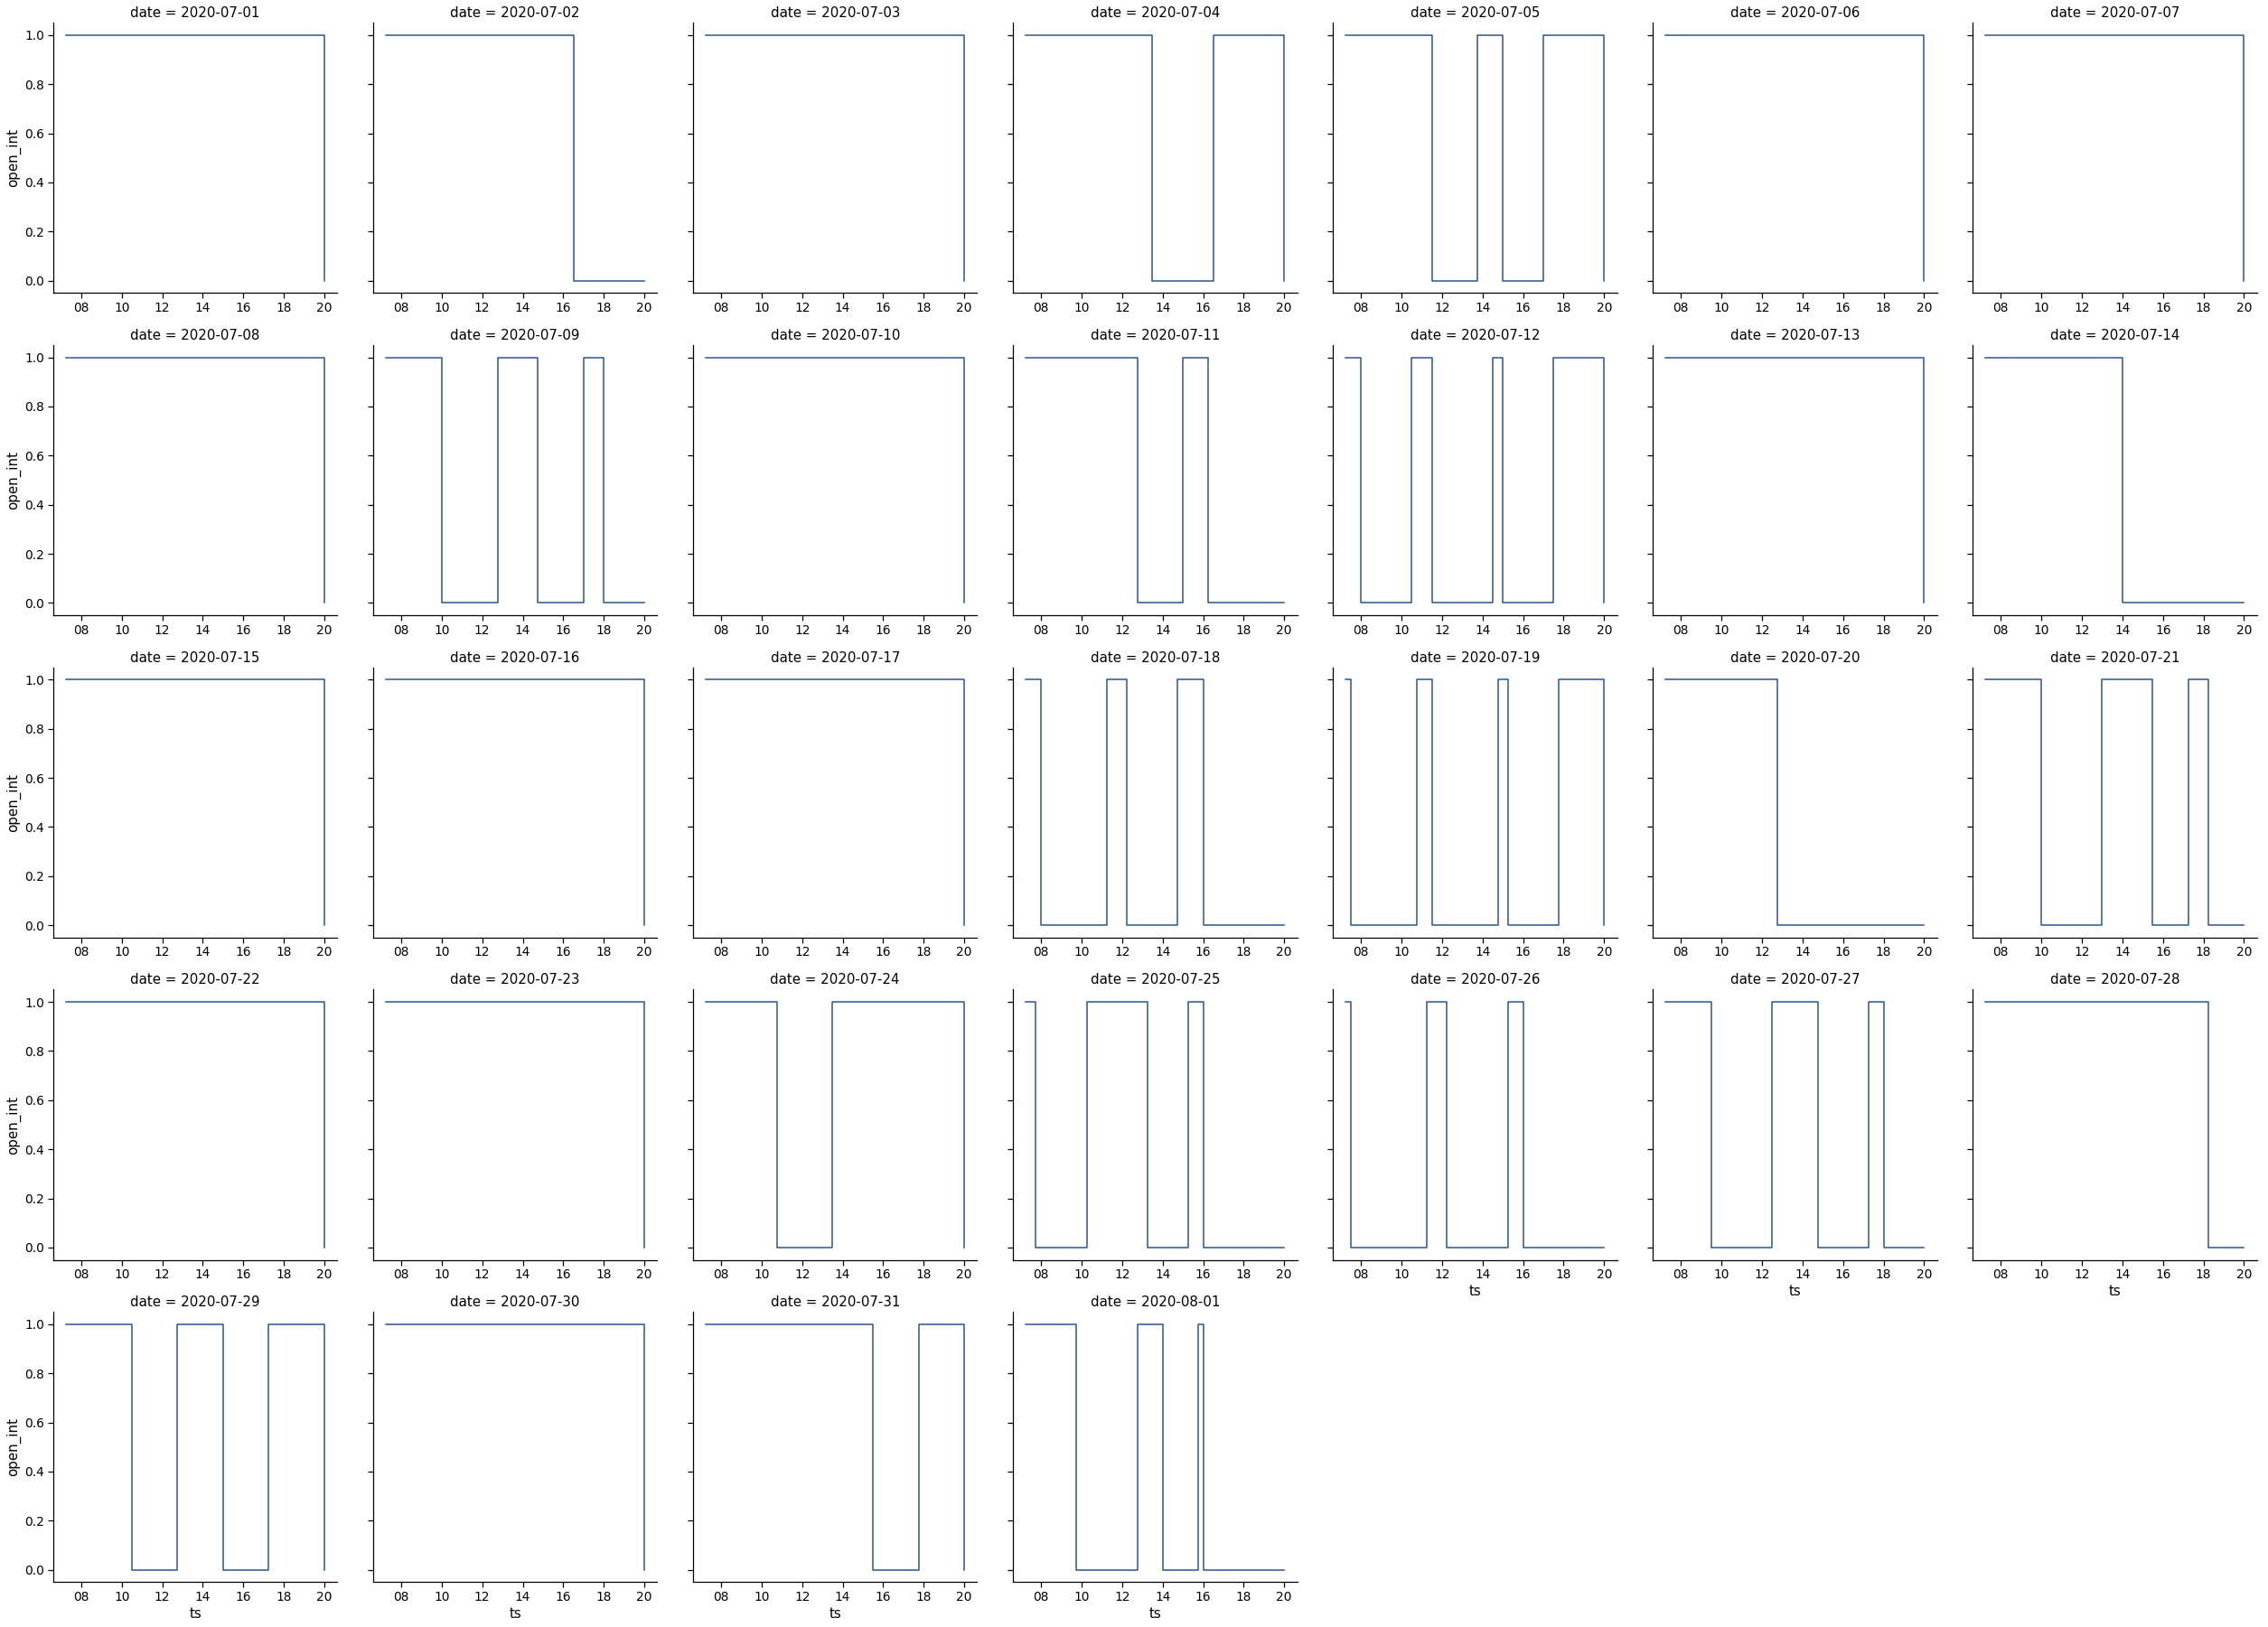

In [63]:
g =  sns.relplot(kind='line',data=dfs,x='ts',y='open_int',col='date',col_wrap=7,drawstyle='steps-post',facet_kws={'sharex':False})
xformatter = mdates.DateFormatter("%H",tz=tz.gettz('EDT'))
for x in g.axes:
    x.xaxis.set_major_formatter(xformatter)


In [74]:
df.corr()

,open,open_int,minutes_since_last_change,last_open_int,holiday|weekend,tmax,tmin
open,1.000000,1.000000,0.269777,0.855817,-0.164424,-0.350322,-0.269759
open_int,1.000000,1.000000,0.269777,0.855817,-0.164424,-0.350322,-0.269759
minutes_since_last_change,0.269777,0.269777,1.000000,0.349858,-0.199156,-0.339494,-0.242188
last_open_int,0.855817,0.855817,0.349858,1.000000,-0.172363,-0.367092,-0.282673
holiday|weekend,-0.164424,-0.164424,-0.199156,-0.172363,1.000000,-0.042600,-0.050252
tmax,-0.350322,-0.350322,-0.339494,-0.367092,-0.042600,1.000000,0.821996
tmin,-0.269759,-0.269759,-0.242188,-0.282673,-0.050252,0.821996,1.000000


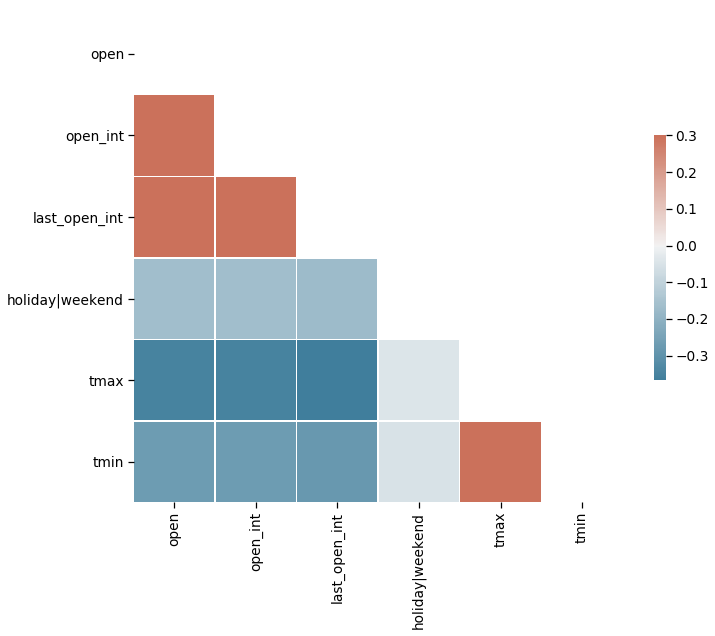

In [38]:

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
df

,created_at,effective_time,open,original_data,text,date,open_int,ts,time_since_last_change,last_open_int,holiday|weekend,tmax,tmin
0,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 07:15:00-04:00,0 days 00:15:00,1,1,81.0,54.0
1,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 07:30:00-04:00,0 days 00:30:00,1,1,81.0,54.0
2,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 07:45:00-04:00,0 days 00:45:00,1,1,81.0,54.0
3,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 08:00:00-04:00,0 days 01:00:00,1,1,81.0,54.0
4,2020-05-03 07:00:00-04:00,2020-05-03 07:00:00-04:00,True,NaN,hardcoded park reopens,2020-05-03,1,2020-05-03 08:15:00-04:00,0 days 01:15:00,1,1,81.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7639,2020-09-26 16:02:20-04:00,2020-09-26 16:01:00-04:00,True,NaN,saturday september 26 2020 effective at 4:0...,2020-09-26,1,2020-09-26 19:00:00-04:00,0 days 02:59:00,1,1,81.0,51.0
7640,2020-09-26 16:02:20-04:00,2020-09-26 16:01:00-04:00,True,NaN,saturday september 26 2020 effective at 4:0...,2020-09-26,1,2020-09-26 19:15:00-04:00,0 days 03:14:00,1,1,81.0,51.0
7641,2020-09-26 16:02:20-04:00,2020-09-26 16:01:00-04:00,True,NaN,saturday september 26 2020 effective at 4:0...,2020-09-26,1,2020-09-26 19:30:00-04:00,0 days 03:29:00,1,1,81.0,51.0
7642,2020-09-26 16:02:20-04:00,2020-09-26 16:01:00-04:00,True,NaN,saturday september 26 2020 effective at 4:0...,2020-09-26,1,2020-09-26 19:45:00-04:00,0 days 03:44:00,1,1,81.0,51.0


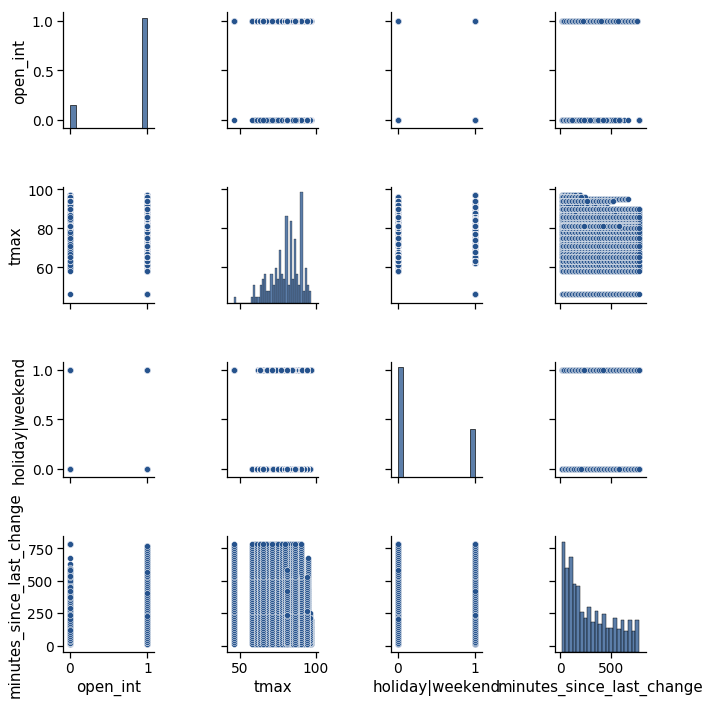

In [76]:
sns.pairplot(data=df[['open_int','tmax','holiday|weekend','minutes_since_last_change']])

                               open  open_int  minutes_since_last_change  \
open                       1.000000  1.000000                   0.269777   
open_int                   1.000000  1.000000                   0.269777   
minutes_since_last_change  0.269777  0.269777                   1.000000   
last_open_int              0.855817  0.855817                   0.349858   
minutes_since_open        -0.182647 -0.182647                   0.639491   
holiday|weekend           -0.164424 -0.164424                  -0.199156   
tmax                      -0.350322 -0.350322                  -0.339494   
tmin                      -0.269759 -0.269759                  -0.242188   

                           last_open_int  minutes_since_open  holiday|weekend  \
open                            0.855817       -1.826473e-01        -0.164424   
open_int                        0.855817       -1.826473e-01        -0.164424   
minutes_since_last_change       0.349858        6.394909e-01        -0.1

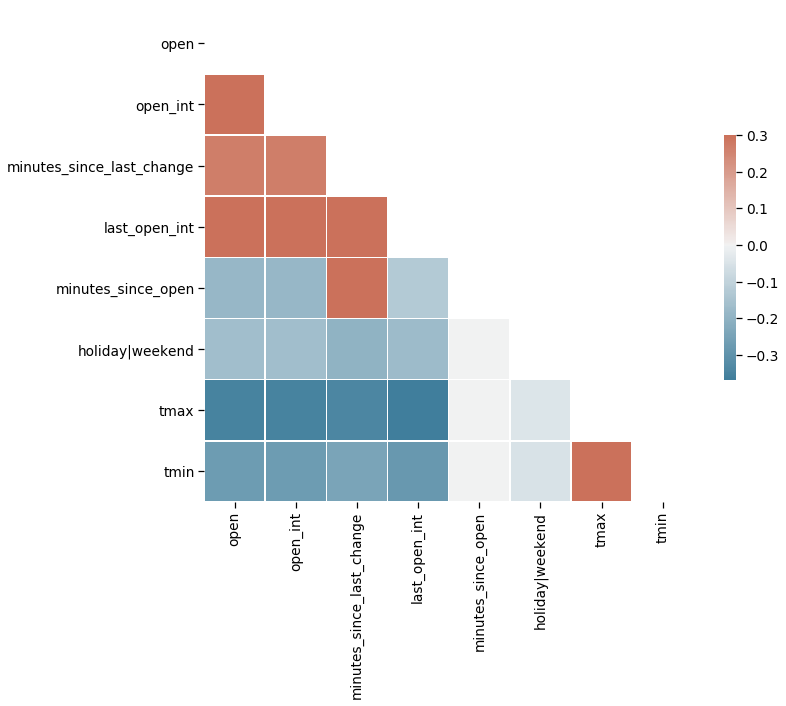

In [137]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print(corr)

# Modeling

There are actually two types of prediction
1. Inconsistent prediction (where we just predict on the val set)
2. Self-consistent use the last prediction as inputs to next one

In [138]:
train_start, train_end = dt.date(2020,5,1), dt.date(2020,7,31)
val_start, val_end = dt.date(2020,8,1), dt.date(2020,8,31)

In [139]:
train = df[df.ts.dt.date.between(train_start, train_end)]
val = df[df.ts.dt.date.between(val_start, val_end)]

In [140]:
otrain = df.loc[(df.ts.dt.date.between(train_start, train_end)) & (df['original_data']==True)]
oval = df.loc[(df.ts.dt.date.between(val_start, val_end)) & (df['original_data']==True)]

In [141]:
from sklearn.linear_model import LogisticRegression 

In [142]:
lr = LogisticRegression()

In [143]:
features = ['minutes_since_last_change','holiday|weekend','tmax']
target = 'open_int'

In [122]:
lr.fit(otrain[features],otrain[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [144]:
lr.fit(train[features],train[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [145]:
val_predict = lr.predict(val[features])

In [146]:
print(classification_report(val[target], val['last_open_int']))

             precision    recall  f1-score   support

          0       0.94      0.86      0.90       367
          1       0.96      0.98      0.97      1245

avg / total       0.95      0.95      0.95      1612



In [147]:
print(classification_report(val[target], val_predict))

             precision    recall  f1-score   support

          0       0.55      0.20      0.29       367
          1       0.80      0.95      0.87      1245

avg / total       0.74      0.78      0.74      1612



In [148]:
print(classification_report(val.loc[val['original_data']==True, 'open_int'], val.loc[val['original_data']==True, 'last_open_int']))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        30
          1       0.00      0.00      0.00        21

avg / total       0.00      0.00      0.00        51



In [149]:
print(classification_report(val.loc[val['original_data']==True, 'open_int'], val_predict[val['original_data']==True]))

             precision    recall  f1-score   support

          0       0.70      0.23      0.35        30
          1       0.44      0.86      0.58        21

avg / total       0.59      0.49      0.44        51



In [150]:
valplot = val.assign(open_int_prediction=val_predict)

In [151]:
valplot = valplot.melt(id_vars=['ts','date'], value_vars=['open_int','open_int_prediction'])

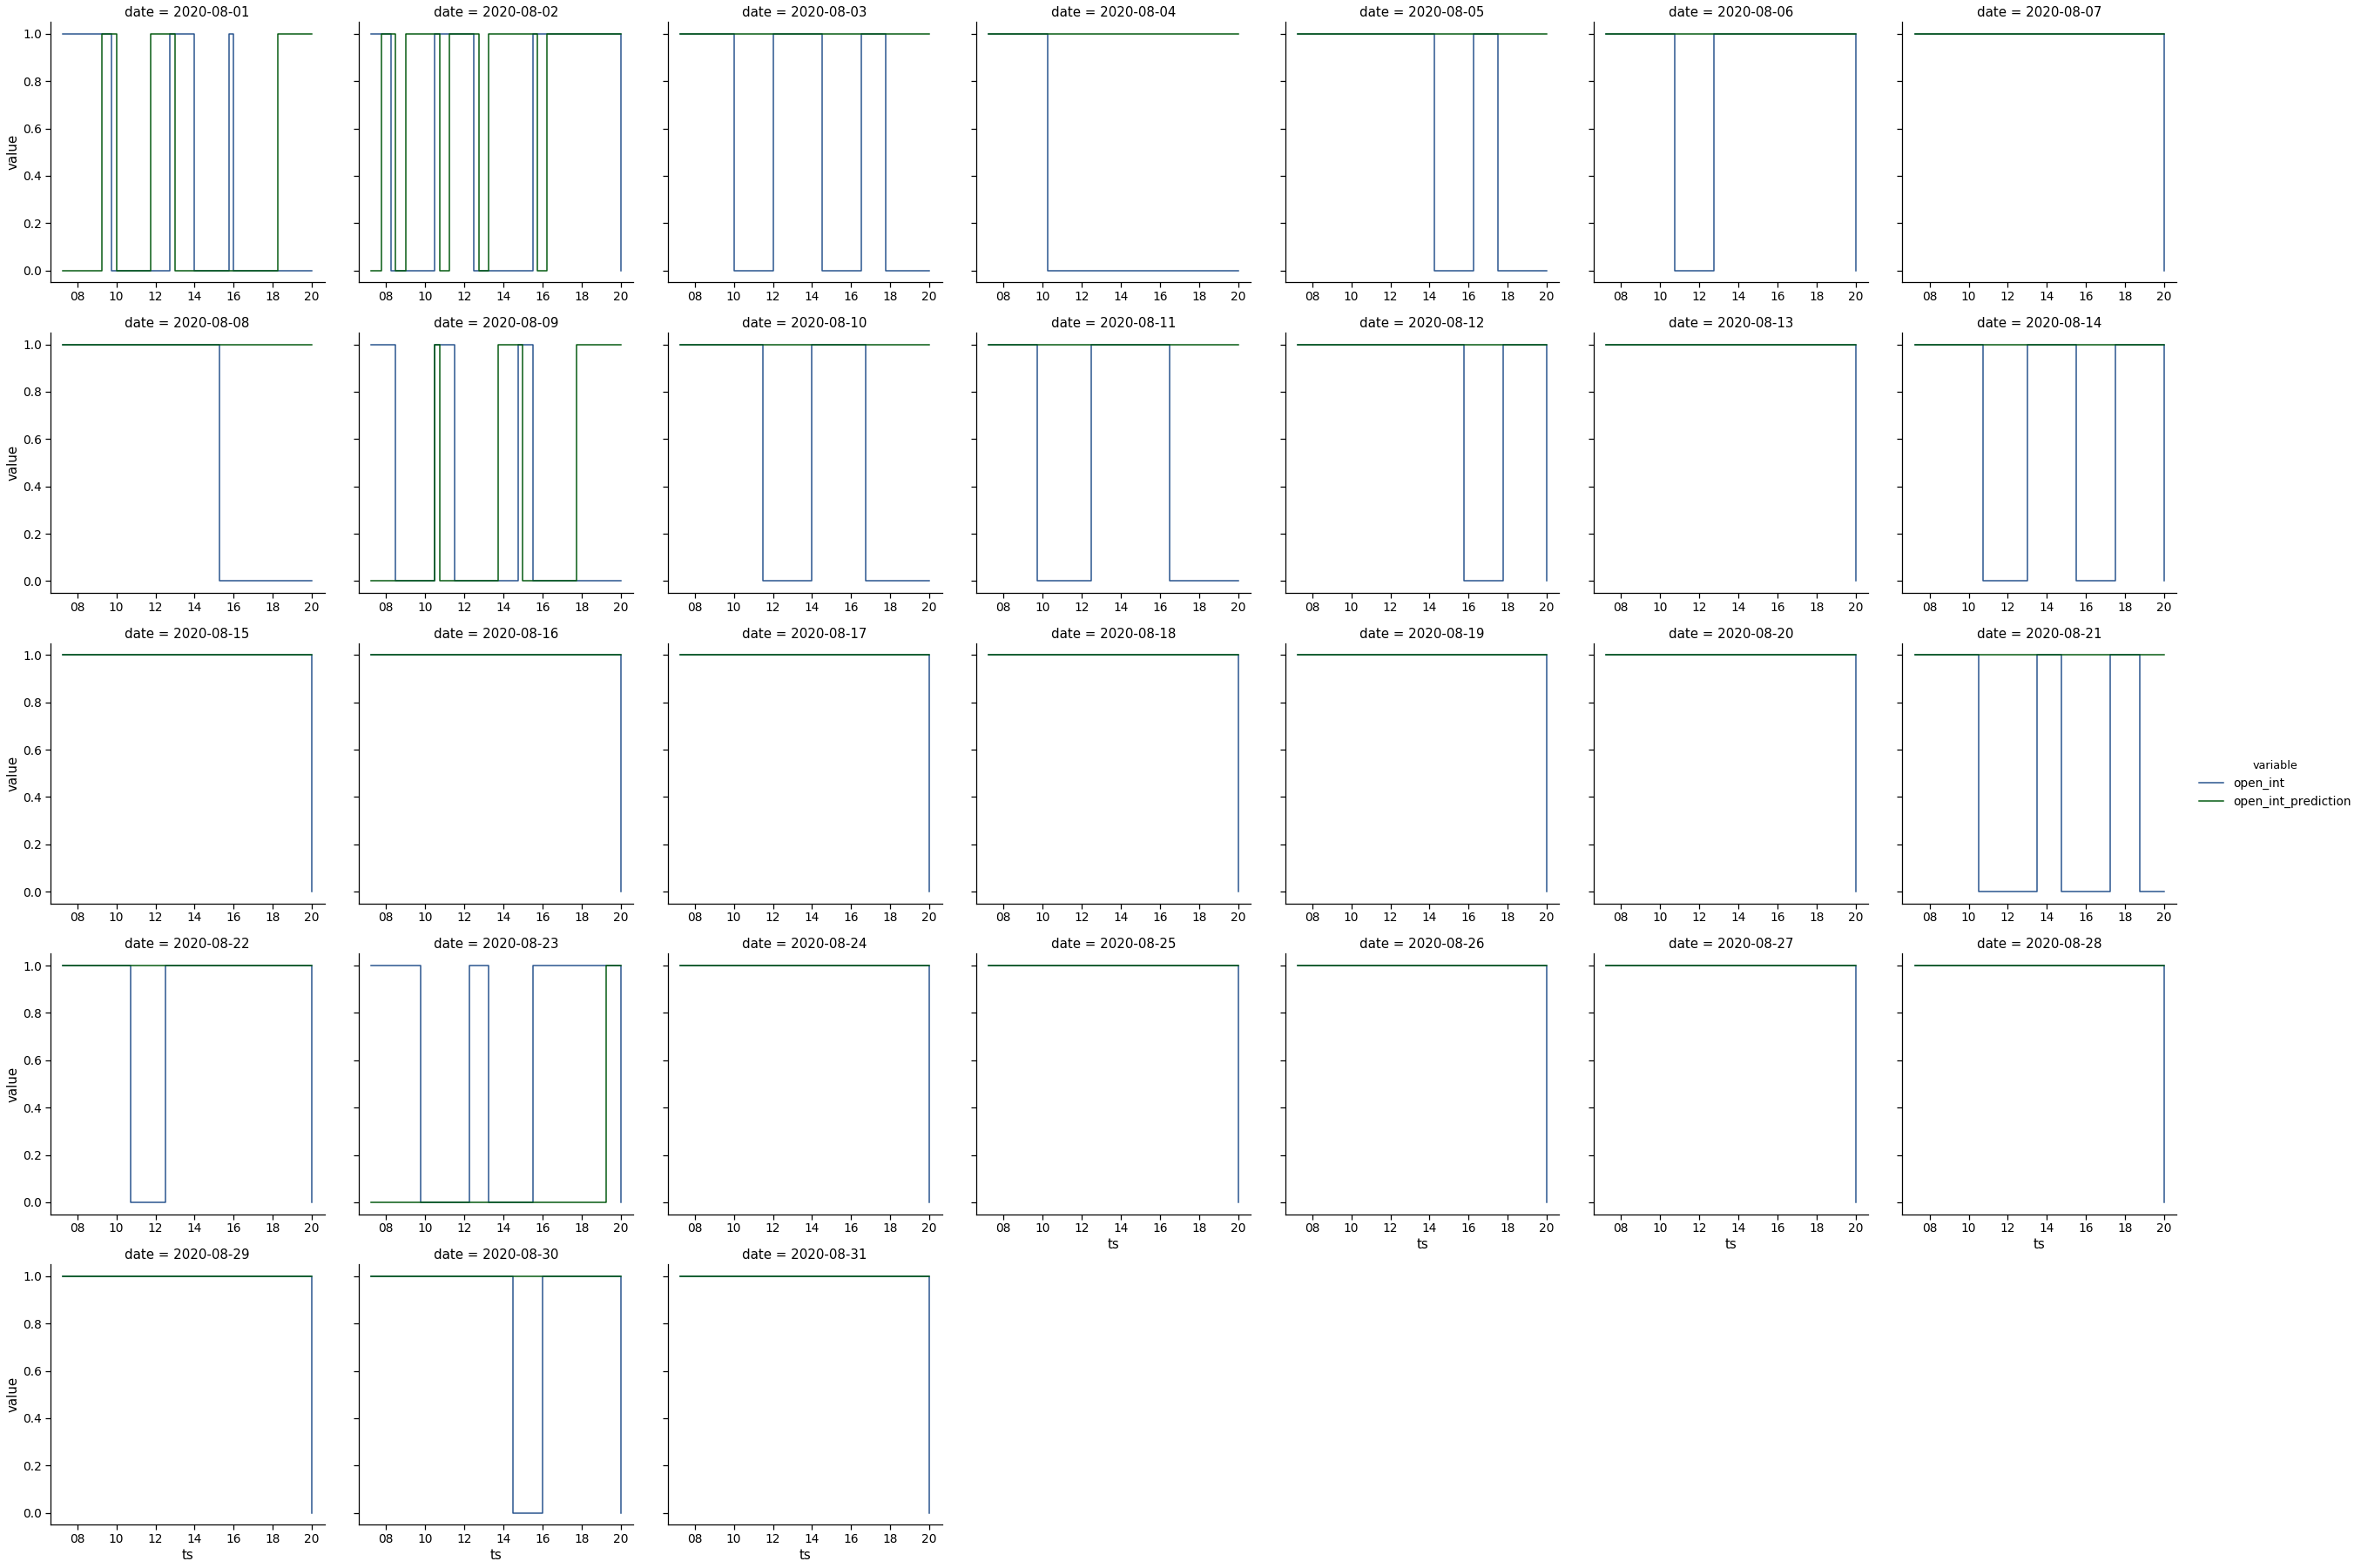

In [152]:
g =  sns.relplot(kind='line',data=valplot,x='ts',y='value',hue='variable', col='date',col_wrap=7,drawstyle='steps-post',facet_kws={'sharex':False})
xformatter = mdates.DateFormatter("%H",tz=tz.gettz('EDT'))
for x in g.axes:
    x.xaxis.set_major_formatter(xformatter)

In [676]:
import attr

In [688]:
import sys
sys.path.insert(0,'~/github/walden_predict/src')

In [692]:
sys.path.insert(0,'/Users/bechtel/github/walden_predict')

In [695]:
from src import tweets

In [97]:
import attr
from attr.validators import instance_of, optional, deep_iterable
import click
import typing as T
import pandas as pd
TZ = 'EST5EDT'

In [900]:
@attr.s
class TweetText:
    text: str = attr.ib(validator=instance_of(str))
        
    def __attrs_post_init__(self):
        # clean up text
        self.text = self.text.lower().replace('-', '').replace(',', ' ')
        
    def parse_effective_hour_str(self) -> T.Optional[str]:
        """ return time from tweet

        e.g. 
        >parse_effective_time_text(' open at 4:00pm')
        >'4:00pm'
        # TODO improve the regex and match logic
        """
        matches = re.findall('((1[0-2]|0?[1-9]):([0-5][0-9])\s?([AaPp][Mm]))|((1[0-2]|0?[1-9])([AaPp][Mm]))',self.text)
        if len(matches)==0:
            return None
        else:
            matches = matches[0]
            reopen_time_str = None 
            for x in matches:
                if x != '':
                    reopen_time_str = x
                    break
            return reopen_time_str
        
        
    @property
    def is_open(self) -> T.Optional[bool]:
        """ Parse text to decide if Pond opening, closing or neither
        
        :returns: True if opening, False if closing, None if neither
        
        """
        reopen = False
        close = False
        
        if 'reopen' in self.text:
            reopen = True
        if 'close' in self.text:
            close = True
            
        if (reopen and close):
            #scan through and take first occurence
            for i in self.text.split(' '):
                if 'reopen' in i:
                    return True
                elif 'close' in i:
                    return False 
                
        elif reopen:
            return True
        elif close:
            return False
        else:
            return None
    

In [901]:
@attr.s
class Tweet:
    created_at: pd.Timestamp = attr.ib(validator=instance_of(pd.Timestamp))
    text: TweetText = attr.ib(validator=instance_of(TweetText))
        
    @classmethod
    def from_dict(cls, d: T.Dict) -> "Tweet":
        return cls(created_at=d['created_at'], text=TweetText(d['text']))
        
        
    @property
    def time_from_text(self) -> T.Optional[pd.Timestamp]:
        """ Tries to parse a time from tweet 
        
        :returns: pd.Timestamp if a time was found, else None
        
        e.g. 
        tweet = Tweet(text='opens at 4:00pm',created_at=pd.Timestamp('2020-07-04 3:00pm'))
        time = tweet.time_from_text
        time
        > Timestamp('2020-07-04 16:00:00-0400', tz='EST5EDT')
        """
        reopen_time = self.text.parse_effective_hour_str()
        if reopen_time is not None:
            date_str = self.created_at.date().strftime('%Y-%m-%d')
            reopen_datetime_str =  date_str + ' ' + reopen_time
            return pd.Timestamp(ts_input=reopen_datetime_str, tz=TZ)
        else:
            return None
    
    @property
    def effective_time(self) -> pd.Timestamp:
        tft = self.time_from_text
        # if time exists and is less than 1 hour from created_at time, use it
        if tft and ((tft-self.created_at).total_seconds()/3600<1):
            return tft
        else:
            return self.created_at
        
    def to_dict(self) -> T.Dict:
        return {"open": self.text.is_open, 
                "effective_time": self.effective_time,
                "created_at": self.created_at, 
                "text": self.text.text}
    
    def to_series(self) -> pd.Series:
        return pd.Series(self.to_dict())
    
    def to_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.to_dict(), index=[0])
    
    def __str__(self) -> str:
        return f"created_at: {self.created_at}\n" \
               f"text: {self.text}"
    def __lt__(self, other: Day) -> bool:
        return self.effective_time < other.effective_time
        
        
    

In [902]:
def num_changes(x):
    return sum(x.iloc[:-1] != x.shift(-1).iloc[:-1])

In [903]:
@attr.s
class Day:
    date: dt.date = attr.ib(validator=instance_of(dt.date))
    open_hour: int = attr.ib(validator=instance_of(int))
    close_hour: int = attr.ib(validator=instance_of(int))
    tweets: T.Sequence[Tweet] = attr.ib(validator=deep_iterable(instance_of(Tweet), instance_of(T.Sequence)))
        
    def __attrs_post_init__(self):
        assert self.open_hour < self.close_hour, "can't close before opening"
        assert (self.close_hour > 12) and (self.close_hour < 22), f"unreasonable close_hour: {self.close_hour}"
        assert all((t.created_at.date() == self.date) for t in self.tweets), f"not all tweets created_at: {self.date}"
        self.tweets = sorted(self.tweets)
#         df = self.to_df().iloc[:-1]
#         changes = num_changes(df['open'])
#         if  changes!=(len(df)-1): 
#             print(f"detected bad parsing of tweets: \n {changes} \n {self.date} \n {df} "
#                   " You should run day.remove_inconsistent_tweets")
        
        
    @classmethod
    def from_raw_df(cls, df: pd.DataFrame, date: dt.date, open_hour: int, close_hour: int) -> "Day":
        assert set(("created_at", "text")).issubset(set(df.columns))
        if not is_datetime(df['created_at']):
            df['created_at'] = pd.to_datetime(df['created_at']).apply(lambda x: x.tz_localize('UTC').tz_convert(TZ))
        df = df[df['created_at'].dt.date == date] 
        tweets = [Tweet.from_dict(df.iloc[i].to_dict()) for i in range(len(df))]
        return cls(date=date, open_hour=open_hour, close_hour=close_hour, tweets=tweets)
        
        
    @property
    def open_timestamp(self) -> pd.Timestamp:
        return pd.Timestamp(f"{self.date} {self.open_hour}:00", tz=TZ)
        
    @property
    def close_timestamp(self) -> pd.Timestamp:
        return pd.Timestamp(f"{self.date} {self.close_hour}:00", tz=TZ)
    
    def remove_inconsistent_tweets(self, inplace: bool=False) -> T.Optional["Day"]:
        # with no dummies, assume park is initially open
        last_open_value = True
        good_tweets = []
        for i, tweet in enumerate(self.tweets):
            if last_open_value==tweet.text.is_open:
                continue
            else:
                good_tweets.append(tweet)
                last_open_value = tweet.text.is_open
        if inplace:
            self.tweets = good_tweets
        else:
            return Day(self.date, 
                       open_hour=self.open_hour, 
                       close_hour=self.close_hour, 
                       tweets=good_tweets) 
        
    def _dummy_open_tweet(self) -> Tweet:
        return Tweet(created_at=self.open_timestamp, text=TweetText('dummy reopen'))
    
    def _dummy_close_tweet(self) -> Tweet:
        return Tweet(created_at=self.close_timestamp, text=TweetText('dummy closed'))
        
    def to_df(self, with_dummies: bool=True) -> pd.DataFrame:
        df = self.tweets
        if with_dummies:
            df = [self._dummy_open_tweet()] + df + [self._dummy_close_tweet()]  
        df = (pd.concat([x.to_df() for x in df], ignore_index=True))
        df = (df\
              .drop_duplicates()\
              .dropna()\
              .sort_values(by='effective_time'))
        return df
        
    def to_time_series(self, resample_freq='1H') -> pd.DataFrame:
        df = self.to_df().sort_values(by='effective_time')
        new_index = pd.date_range(start=self.open_timestamp, 
                                  end=self.close_timestamp, 
                                  freq=resample_freq, tz=TZ)
        df = (df.set_index('effective_time', drop=False)\
              .reindex(new_index, method='ffill'))
        df.index.name = 'time'
        df['date'] = self.date
        return df
    
    def to_time_intervals(self) -> pd.DataFrame:
        df = self.to_df()
        intervals = []
        opens = []
        for i in range(len(df)-1):
            intervals.append(pd.Interval(df.iloc[i]['effective_time'],
                                         df.iloc[i+1]['effective_time'],
                                         closed='both'))
            opens.append(df.iloc[i]['open'])
        df = pd.DataFrame({'open':opens, 'intervals': intervals})
        df['length'] = df['intervals'].apply(lambda x: x.length)
        df['date'] = self.date
        return df

In [904]:
@attr.s
class Season:
    days: T.Sequence[Day] = attr.ib(validator=deep_iterable(instance_of(Day), instance_of(T.Sequence)))
        
    @classmethod
    def from_raw_df(cls, df: pd.DataFrame, start_date: dt.date, end_date: dt.date, 
                    open_hour: T.Union[T.Sequence[int],int], 
                    close_hour: T.Union[T.Sequence[int],int],
                   ) -> "Season":
        assert set(("created_at", "text")).issubset(set(df.columns))
        assert type(open_hour)==type(close_hour)
        date_range = pd.date_range(start_date, end_date, freq='1D')
        ndays = len(date_range)
        if type(open_hour)!=int:
            assert len(open_hour)==ndays
            assert len(open_hour)==len(close_hour)
        else:
            open_hour = [open_hour]*ndays
            close_hour = [close_hour]*ndays
        if not is_datetime(df['created_at']):
            df['created_at'] = pd.to_datetime(df['created_at']).apply(lambda x: x.tz_localize('UTC').tz_convert(TZ))
            
        df = df[(df['created_at'].dt.date >= start_date) & (df['created_at'].dt.date <= end_date)] 
        days = [Day.from_raw_df(df=df, date=d, open_hour=oh, close_hour=ch) 
                for d,oh,ch in zip(date_range, open_hour, close_hour)]
        return cls(days=days)
    
    def remove_inconsistent_tweets(self, inplace: bool=False) -> T.Optional["Season"]:
        # if inplace, this returns nothing, and our job is done
        consistent_days = [d.remove_inconsistent_tweets(inplace=inplace) for d in self.days]
        # if not inplace, we have the good days, now remake a Season
        if not inplace:
            return Season(days=consistent_days)
    
    def to_df(self):
        return pd.concat([x.to_df() for x in self.days], ignore_index=True)
    
    def to_time_series(self):
        return pd.concat([x.to_time_series() for x in self.days])
    
    def to_time_intervals(self):
        return pd.concat([x.to_time_intervals() for x in self.days])

In [669]:


def pre_process_tweet_csv(filename: str, start_dt: pd.Timestamp, end_dt: pd.Timestamp) -> pd.DataFrame:
    df = pd.read_csv(filename,parse_dates=['created_at'])
    df['created_at'] = df['created_at'].apply(lambda x: x.tz_localize('UTC').tz_convert(TZ))
    df['date'] = df['created_at'].dt.date
    return df

In [670]:

filename='../data/new_waldenpondstate_tweets.csv'
start_dt = pd.Timestamp('2020-05-01',tz=TZ)
end_dt = pd.Timestamp('2020-10-01',tz=TZ)

In [671]:
df = pd.read_csv(filename)

In [688]:
season = Season.from_raw_df(df, 
                            start_date=dt.date(2020,7,1), 
                            end_date=dt.date(2020,8,2), 
                            open_hour=7,
                            close_hour=20
                            )

detected bad parsing of tweets: 
 1 
 2020-07-02 00:00:00 
     open            effective_time                created_at  \
0   True 2020-07-02 07:00:00-04:00 2020-07-02 07:00:00-04:00   
1   True 2020-07-02 14:49:35-04:00 2020-07-02 14:49:35-04:00   
2  False 2020-07-02 16:30:00-04:00 2020-07-02 16:40:06-04:00   

                                                text  
0                                       dummy reopen  
1  thursday july 2  2020  walden pond has passed ...  
2  thursday 7/2/2020 at 4:30pm walden pond state ...    You should run day.remove_inconsistent_tweets
detected bad parsing of tweets: 
 1 
 2020-07-20 00:00:00 
     open            effective_time                created_at  \
0   True 2020-07-20 07:00:00-04:00 2020-07-20 07:00:00-04:00   
1  False 2020-07-20 12:44:01-04:00 2020-07-20 12:44:01-04:00   
2  False 2020-07-20 16:38:00-04:00 2020-07-20 16:36:12-04:00   
3  False 2020-07-20 16:38:00-04:00 2020-07-20 16:44:32-04:00   

                                   

In [689]:
# season2.remove_inconsistent_tweets()

In [690]:
season2 = season.remove_inconsistent_tweets(inplace=False)

In [691]:
season2.to_time_series()

,open,effective_time,created_at,text,date
time,,,,,
2020-07-01 07:00:00-04:00,True,2020-07-01 07:00:00-04:00,2020-07-01 07:00:00-04:00,dummy reopen,2020-07-01
2020-07-01 08:00:00-04:00,True,2020-07-01 07:00:00-04:00,2020-07-01 07:00:00-04:00,dummy reopen,2020-07-01
2020-07-01 09:00:00-04:00,True,2020-07-01 07:00:00-04:00,2020-07-01 07:00:00-04:00,dummy reopen,2020-07-01
2020-07-01 10:00:00-04:00,True,2020-07-01 07:00:00-04:00,2020-07-01 07:00:00-04:00,dummy reopen,2020-07-01
2020-07-01 11:00:00-04:00,True,2020-07-01 07:00:00-04:00,2020-07-01 07:00:00-04:00,dummy reopen,2020-07-01
...,...,...,...,...,...
2020-08-02 16:00:00-04:00,True,2020-08-02 15:30:00-04:00,2020-08-02 15:29:12-04:00,sunday august 2 2020 effective at 3:30pm p...,2020-08-02
2020-08-02 17:00:00-04:00,True,2020-08-02 15:30:00-04:00,2020-08-02 15:29:12-04:00,sunday august 2 2020 effective at 3:30pm p...,2020-08-02
2020-08-02 18:00:00-04:00,True,2020-08-02 15:30:00-04:00,2020-08-02 15:29:12-04:00,sunday august 2 2020 effective at 3:30pm p...,2020-08-02


In [694]:
season2.to_df().shape

(138, 4)

In [695]:
season.to_df().shape

(142, 4)

In [681]:
season2.to_time_intervals()

,open,intervals,length,date
0,True,"[2020-07-01 07:00:00, 2020-07-01 20:00:00]",0 days 13:00:00,2020-07-01
0,True,"[2020-07-02 07:00:00, 2020-07-02 16:30:00]",0 days 09:30:00,2020-07-02
1,False,"[2020-07-02 16:30:00, 2020-07-02 20:00:00]",0 days 03:30:00,2020-07-02
0,True,"[2020-07-03 07:00:00, 2020-07-03 20:00:00]",0 days 13:00:00,2020-07-03
0,True,"[2020-07-04 07:00:00, 2020-07-04 13:21:00]",0 days 06:21:00,2020-07-04
...,...,...,...,...
3,False,"[2020-08-05 17:23:00, 2020-08-05 20:00:00]",0 days 02:37:00,2020-08-05
0,True,"[2020-08-06 07:00:00, 2020-08-06 10:33:00]",0 days 03:33:00,2020-08-06
1,False,"[2020-08-06 10:33:00, 2020-08-06 12:38:00]",0 days 02:05:00,2020-08-06
2,True,"[2020-08-06 12:38:00, 2020-08-06 20:00:00]",0 days 07:22:00,2020-08-06


In [682]:
season.to_time_series()

ValueError: cannot reindex a non-unique index with a method or limit

In [338]:
day = Day.from_raw_df(df=df, date=pd.Timestamp('2020-07-02').date(), open_hour=7, close_hour=20)

In [339]:
day.to_df()

,open,effective_time,created_at,text
0,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2,True,2020-07-02 14:49:35-04:00,2020-07-02 14:49:35-04:00,thursday july 2 2020 walden pond has passed ...
1,False,2020-07-02 16:30:00-04:00,2020-07-02 16:40:06-04:00,thursday 7/2/2020 at 4:30pm walden pond state ...
3,False,2020-07-02 20:00:00-04:00,2020-07-02 20:00:00-04:00,dummy closed


In [340]:
day.to_time_intervals()

,open,intervals,length
0,True,"[2020-07-02 07:00:00, 2020-07-02 14:49:35]",0 days 07:49:35
1,True,"[2020-07-02 14:49:35, 2020-07-02 16:30:00]",0 days 01:40:25
2,False,"[2020-07-02 16:30:00, 2020-07-02 20:00:00]",0 days 03:30:00


In [272]:
pd.Interval()

pandas._libs.interval.Interval

In [260]:
ts = day.to_time_series()

    open            effective_time                created_at  \
0   True 2020-07-02 07:00:00-04:00 2020-07-02 07:00:00-04:00   
1  False 2020-07-02 16:30:00-04:00 2020-07-02 16:40:06-04:00   
2   True 2020-07-02 19:00:00-04:00 2020-07-02 14:49:35-04:00   
3  False 2020-07-02 20:00:00-04:00 2020-07-02 20:00:00-04:00   

                                                text  
0                                       dummy reopen  
1  thursday 7/2/2020 at 4:30pm walden pond state ...  
2  thursday july 2  2020  walden pond has passed ...  
3                                       dummy closed  


In [261]:
ts
    

,open,effective_time,created_at,text
time,,,,
2020-07-02 07:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 08:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 09:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 10:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 11:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 12:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 13:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 14:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2020-07-02 15:00:00-04:00,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen


In [262]:
tdf = day.to_df()

    open            effective_time                created_at  \
0   True 2020-07-02 07:00:00-04:00 2020-07-02 07:00:00-04:00   
1  False 2020-07-02 16:30:00-04:00 2020-07-02 16:40:06-04:00   
2   True 2020-07-02 19:00:00-04:00 2020-07-02 14:49:35-04:00   
3  False 2020-07-02 20:00:00-04:00 2020-07-02 20:00:00-04:00   

                                                text  
0                                       dummy reopen  
1  thursday 7/2/2020 at 4:30pm walden pond state ...  
2  thursday july 2  2020  walden pond has passed ...  
3                                       dummy closed  


In [263]:
tdf

,open,effective_time,created_at,text
0,True,2020-07-02 07:00:00-04:00,2020-07-02 07:00:00-04:00,dummy reopen
2,True,2020-07-02 19:00:00-04:00,2020-07-02 14:49:35-04:00,thursday july 2 2020 walden pond has passed ...
1,False,2020-07-02 16:30:00-04:00,2020-07-02 16:40:06-04:00,thursday 7/2/2020 at 4:30pm walden pond state ...
3,False,2020-07-02 20:00:00-04:00,2020-07-02 20:00:00-04:00,dummy closed


In [196]:
tdf.iloc[1]['text']

'thursday july 2  2020  walden pond has passed its water quality retesting. swimming has reopened at main and red cross beaches. the bath house is open until 7pm. for more information regarding water quality at dcr beaches  please call the dcr beaches hotline at (617) 6264972.'